In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal

In [2]:
def count_spanning_trees_log(g):
    L = gt.laplacian(g).toarray()
    L_minor = L[1:, 1:]
    # 行列式の対数値を返す
    sign, logdet = np.linalg.slogdet(L_minor)
    if sign <= 0:
        return np.nan  # 負やゼロの場合はNaN
    return logdet

In [3]:
Node = 1000
m = 2
times = 100
M_list = [4, 8, 10, 20]
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
w_list = [Decimal("0.00"), Decimal("0.50"), Decimal("0.70"), Decimal("0.90"), Decimal("0.95"), Decimal("0.98")]

In [4]:
for M in M_list:
    for beta in beta_list:
        records = []
        for W in w_list:
            for i in tqdm(range(times)):
                g = gt.load_graph(f"~/o_t_hayashilab/network_data/graph-tool/modular_network/N={Node}/m={m}/beta={beta}/w={W}/Mo={M}/{i}.gt.gz")
                # 最大連結成分で計算
                l = gt.label_largest_component(g)
                u = gt.GraphView(g, vfilt=l)
                # モジュラリティ
                state = gt.BlockState(g, b=g.vp.module_number)
                Q = gt.modularity(g, state.get_blocks())
                # log(全域木数)
                log_n_trees = count_spanning_trees_log(u)
                records.append({"modularity": Q, "log_n_trees": log_n_trees, "w": float(W)})
        df = pd.DataFrame(records)
        df.to_csv(f"~/o_t_hayashilab/network_code/result/mo{M}_beta{beta}_modularity_vs_log_spanning_trees.csv", index=False)

100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


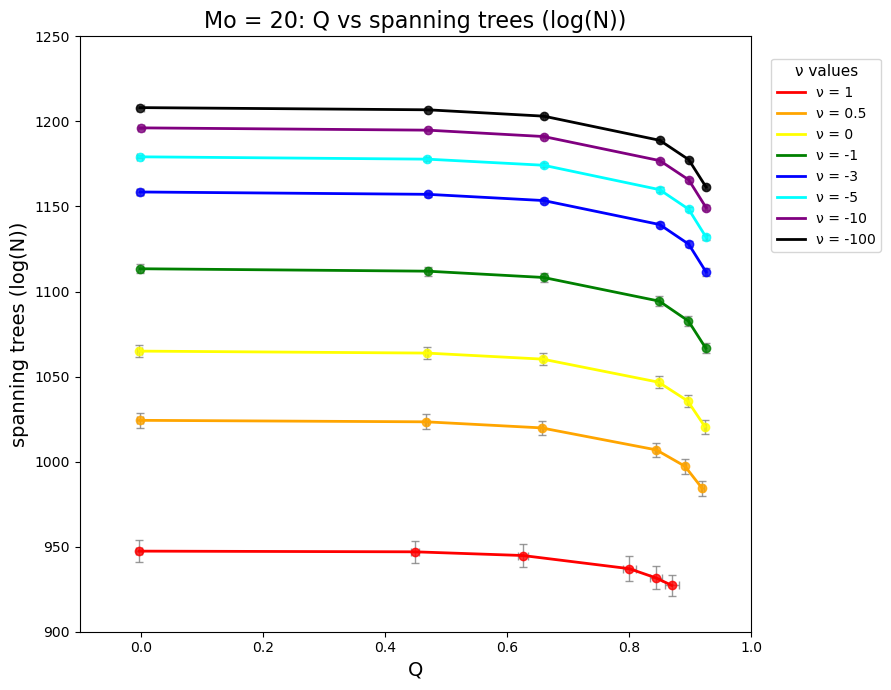

In [8]:
color_list = [
    "red",       # β = 1
    "orange",    # β = 0.5
    "yellow",    # β = 0
    "green",     # β = -1
    "blue",      # β = -3
    "cyan",      # β = -5
    "purple",    # β = -10
    "black",     # β = -100
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# betaのリストと色の固定対応
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
color_list = ["red", "orange", "yellow", "green", "blue", "cyan", "purple", "black"]
color_map = dict(zip(beta_list, color_list))

w_list = [0.00, 0.50, 0.70, 0.90, 0.95, 0.98]
Mo = 20

plt.figure(figsize=(9, 7))

for beta in beta_list:
    # mo=4
    df4 = pd.read_csv(f"~/o_t_hayashilab/network_code/result/mo{Mo}_beta{beta}_modularity_vs_log_spanning_trees.csv")
    df4 = df4[df4["w"].isin(w_list)]

    means4 = df4.groupby("w").agg({"modularity": "mean", "log_n_trees": "mean"})
    stds4 = df4.groupby("w").agg({"modularity": "std", "log_n_trees": "std"})

    for w in w_list:
        sub = df4[df4["w"] == w]
        mean_mod = sub["modularity"].mean()
        mean_log_n = sub["log_n_trees"].mean()
        std_mod = sub["modularity"].std()
        std_log_n = sub["log_n_trees"].std()

        plt.errorbar(mean_mod, mean_log_n, xerr=std_mod, yerr=std_log_n,
                     fmt='o', color=color_map[beta], ecolor="gray", elinewidth=1, capsize=3, alpha=0.8)
        
    plt.plot(means4["modularity"], means4["log_n_trees"], '-', linewidth=2, color=color_map[beta], label=f"ν = {beta}")

plt.xlabel("Q", fontsize=14)
plt.ylabel("spanning trees (log(N))", fontsize=14)
plt.title(f"Mo = {Mo}: Q vs spanning trees (log(N))", fontsize=16)
plt.xlim(-0.1, 1.0)
plt.ylim(900, 1250)
plt.legend(
    title="ν values",
    fontsize=10,
    title_fontsize=11,
    loc="center left",         # 凡例の表示位置（右端中央）
    bbox_to_anchor=(1.02, 0.8) # グラフ外に少し離して配置
)
plt.grid(False)
plt.subplots_adjust(right=0.8)  # ← これを追加！
plt.tight_layout()
plt.show()